# Counting Stars (V3)

In [4]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from astropy.io import fits
from astropy.utils.data import download_file
imgFile = download_file('http://data.astropy.org/tutorials/FITS-images/HorseHead.fits', cache=True)

In [5]:
hdulist = fits.open(imgFile)
img = hdulist[0].data

In [6]:
hdulist[0].header

SIMPLE  =                    T /FITS: Compliance                                
BITPIX  =                   16 /FITS: I*2 Data                                  
NAXIS   =                    2 /FITS: 2-D Image Data                            
NAXIS1  =                  891 /FITS: X Dimension                               
NAXIS2  =                  893 /FITS: Y Dimension                               
EXTEND  =                    T /FITS: File can contain extensions               
DATE    = '2014-01-09        '  /FITS: Creation Date                            
ORIGIN  = 'STScI/MAST'         /GSSS: STScI Digitized Sky Survey                
SURVEY  = 'SERC-ER '           /GSSS: Sky Survey                                
REGION  = 'ER768   '           /GSSS: Region Name                               
PLATEID = 'A0JP    '           /GSSS: Plate ID                                  
SCANNUM = '01      '           /GSSS: Scan Number                               
DSCNDNUM= '00      '        

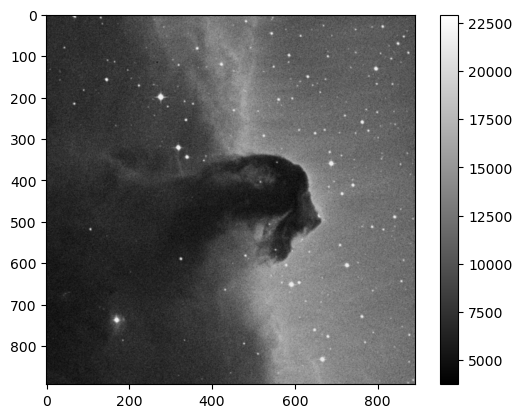

In [7]:
plt.imshow(img, cmap='gray')
plt.colorbar()

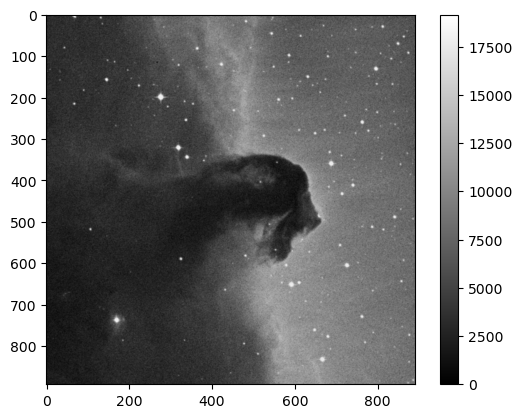

In [8]:
img2 = np.zeros(img.shape)
for i in range(len(img2)):
    for j in range(len(img2[0])):
        img2[i, j] = img[i,j] - 3759

plt.imshow(img2, cmap='gray')
plt.colorbar()

## Annulus

In [9]:
from PIL import Image
im_frame = Image.open('/home/saphio/Downloads/bigger_ann.png')

In [10]:
annulus_size = 26

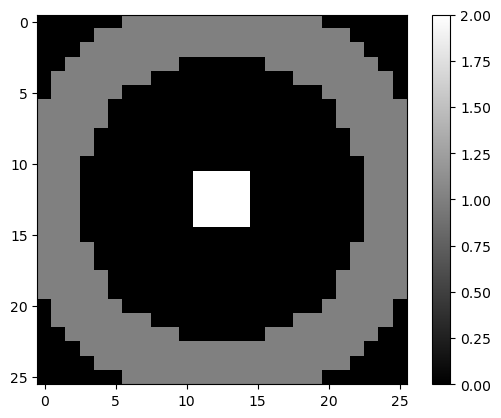

In [11]:
np_frame = np.array(im_frame)
annulus = np.zeros((annulus_size, annulus_size))
for i in range(len(np_frame)):
    for j in range(len(np_frame[0])):
        if (np_frame[i, j, 0] == 0 and np_frame[i, j, 3] == 255):
            annulus[i, j] = 1 ## background
        elif (np_frame[i, j, 0] == 112):
            annulus[i, j] = 2 ## star

plt.imshow(annulus, cmap='gray')
plt.colorbar()

In [12]:
circle_pixels = annulus[annulus == 2].shape[0]
annulus_pixels = annulus[annulus == 1].shape[0]

circle_pixels, annulus_pixels

(16, 292)

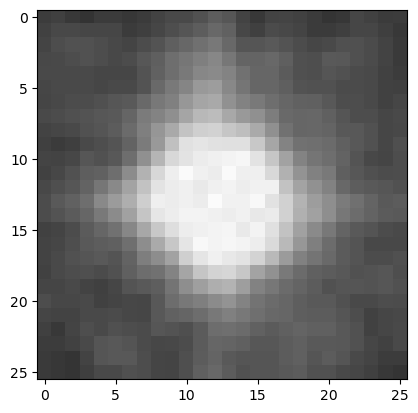

In [42]:
#testImg = img[248:274, 751:777]
testImg = img[725:751, 158:184]
plt.imshow(testImg, cmap='gray', vmin = 3759, vmax = 22918) 

## SNR: around 130

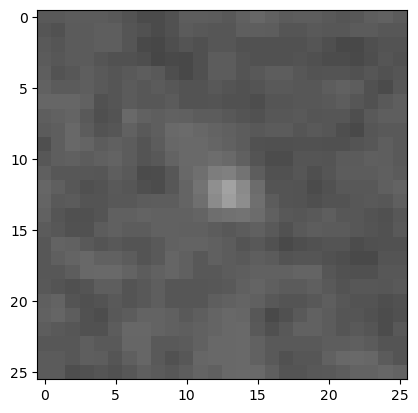

In [61]:
plt.imshow(img[64:90, 815:841], cmap='gray', vmin = 3759, vmax = 22918)
testImg = img[64:90, 815:841]

## SNR: around 25

In [53]:
## Summing counts

circle_counts = 0
annulus_counts = 0

for i in range(annulus_size):
    for j in range(annulus_size):
        if (annulus[i, j] == 2):
            circle_counts += testImg[i, j]
        elif (annulus[i, j] == 1):
            annulus_counts += testImg[i, j]
            
print('circle counts:', circle_counts)
print('annulus counts:', annulus_counts)

circle counts: 212410
annulus counts: 3053546


In [54]:
gain = 8

In [55]:
# Sky background per Pixel (N_s)
sky_bg_pixel = annulus_counts/annulus_pixels # * gain

# Signal in Aperture (N_T)
signal_aperture = (circle_counts - circle_pixels * annulus_counts / annulus_pixels) # * gain

In [56]:
print('sky background/pixel', sky_bg_pixel)
print('signal in aperture', signal_aperture)

sky background/pixel 10457.349315068494
signal in aperture 45092.4109589041


In [57]:
# Noise from signal
signal_noise = np.sqrt(signal_aperture)

# Noise from Sky
sky_noise = np.sqrt(annulus_pixels * sky_bg_pixel)

In [58]:
print('signal noise', signal_noise)
print('sky noise', sky_noise)

signal noise 212.34973736481075
sky noise 1747.439841596843


In [59]:
# Total noise
total_noise = np.sqrt(signal_aperture + 
                     annulus_pixels * sky_bg_pixel)

print('total noise', total_noise)

total noise 1760.294978393935


In [60]:
print('S/N', signal_aperture/total_noise)

S/N 25.616394702236608


https://homepage.physics.uiowa.edu/~haifu//assets/pdf/astrolab/6.snr.pdf

In [75]:
def calculate_ratio (testImg, x, y):
    ## Summing counts

    circle_counts = 0
    annulus_counts = 0
    
    circle_pixels = 0
    annulus_pixels = 0

    for i in range(annulus_size):
        for j in range(annulus_size):
            try:
                if (annulus[i, j] == 2):
                    circle_counts += testImg[i + x, j + y]
                    circle_pixels += 1
                elif (annulus[i, j] == 1):
                    annulus_counts += testImg[i + x, j + y]
                    annulus_pixels += 1
            except:
                pass
                
    # Sky background per Pixel (N_s)
    sky_bg_pixel = annulus_counts / annulus_pixels

    # Signal in Aperture (N_T)
    signal = (circle_counts - (circle_pixels * annulus_counts / annulus_pixels))
    
    # Total noise = sqrt(N_T + N_s * npix + other stuff (dark current, readout))
    total_noise = np.sqrt(signal + (circle_pixels * annulus_counts / annulus_pixels))
    if (total_noise == 0):
        total_noise = 0.01
    
    return signal/total_noise

## Testing out Ratios (Larger Scale)

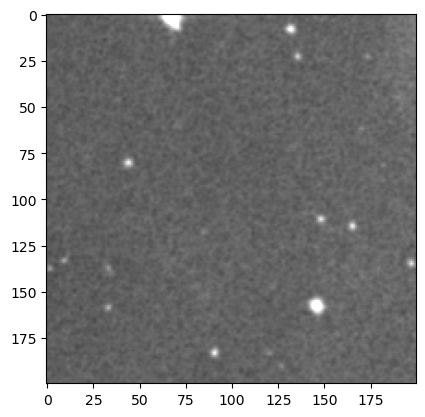

In [78]:
smallImg = img[:200, :200]
plt.imshow(smallImg, cmap='gray', vmin=0, vmax=22918-3759)

In [79]:
marks = np.zeros(smallImg.shape)
for i in range(-13, len(smallImg) - 13):
    for j in range(-13, len(smallImg[0]) - 13):
        marks[i + 13, j + 13] = calculate_ratio(smallImg, i, j)

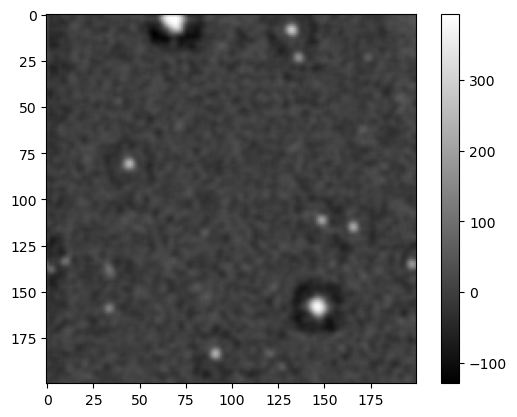

In [80]:
plt.imshow(marks, cmap='gray')
plt.colorbar()

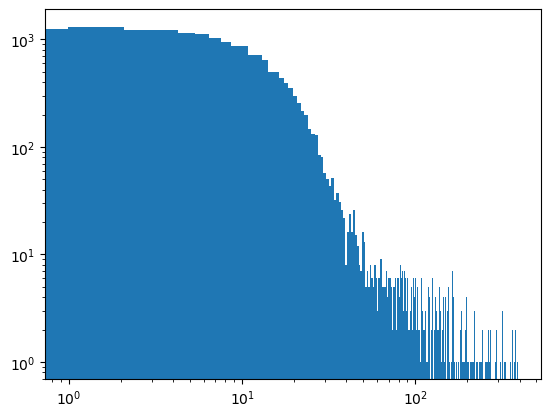

In [85]:
smallImgHist = plt.hist(marks.flatten(), bins='auto')
plt.xscale('log')
plt.yscale('log')

In [81]:
marks_cut = np.zeros(marks.shape)

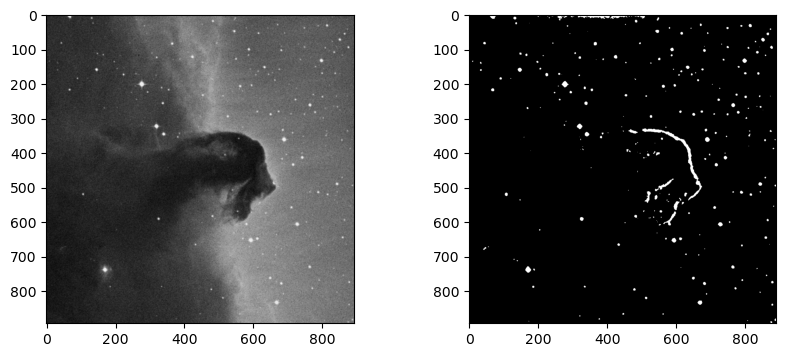

In [70]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
for i in range(len(marks)):
    for j in range(len(marks[0])):
        if (marks[i, j] >= ):
            marks_cut[i, j] = 100
        else:
            marks_cut[i, j] = 0

axes[0].imshow(img, cmap='gray')
axes[1].imshow(marks_cut, cmap='gray')

## Counting the Stars

In [71]:
def neighbor (matrix, i, j):
    try:
        if (matrix[i - 1][j] or 
            matrix[i - 1][j - 1] or
            matrix[i - 1][j + 1] or
            matrix[i][j - 1]):
            return 0
        else:
            return 1
    except:
        return -1

In [72]:
matrix = [[False for i in range(len(img[0]))] for j in range(len(img))]

count = 0

for i in range(len(marks_cut)):
    for j in range(len(marks_cut[0])):
        if (marks_cut[i, j] == 100):
            matrix[i][j] = True
            if (neighbor(matrix, i, j) == 1):
                count += 1
        else:
            matrix[i][j] = False

In [73]:
count

347